## Gradient ascent

### Importing libraries

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.style.use("science")
import cvxpy as cp
import math
import matplotlib as mpl
from random import shuffle
import pandas as pd

### Semi discrete optimal transport

<font color="blue">
$$
\begin{align}
\text{min} \big\{ \int_X \sum_j c_{T}(x, y_j) d\gamma_j(x) : \int_X d\gamma_j(x) = \nu_j, \sum_j d\gamma_j(x) = d\mu(x) \big\}
\end{align}
$$
</font>

where
- $\mu(x) \sim X$ is a continuous distribution
- $\nu \sim Y$ is a discrete distribution
- $c_T(x, y_j) = \frac{1}{2}(x - y_j)^2$ is the cost function

### Generate a problem

**Continuous distribution $\mu(x) \sim X = N(0, 1)$ and a discrete distribution $\nu \sim Y$**

In [2]:
data = pd.read_csv("../datasets/gaussians_double.csv")
x = data["x"]
y = data["y"]
N = x.size
M = y.size

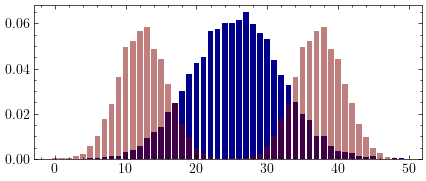

In [11]:
fig, ax = plt.subplots(figsize=(5, 2)) 
plt.bar(range(N), x, color = "darkblue")
plt.bar(range(M), y, color = "maroon", alpha = 0.5)
plt.show()

### Distance matrix

$$C = d(x_i, y_j) = \frac{1}{2}(x_i - y_j)^2$$

$$i = \{1, 2, \ldots, M\} \ \text{and} \ j = \{1, 2, \ldots, N\}$$

In [12]:
C = np.zeros((M, N))
for i in range(M):
    for j in range(N):
        C[i, j] = .5 * (x[i] - y[j])**2

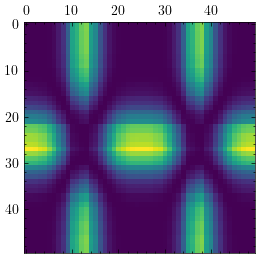

In [13]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(C)
plt.show()

### Gradient ascent algorithm

**Dual formulation**

<font color="blue">
$$\sup_{\psi, \phi} \big\{ \sum_j\psi_j\nu_j + \int_X \phi(x) d\mu(x) : \psi_j + \phi(x) \leq c(x, y_j) \big\}$$
</font>

which is equivalent to

<font color="blue">
$$\sup_{\psi} \big\{ \sum_j\psi_j\nu_j + \int_X \inf_{j}[c(x, y_j) - \psi_j] d\mu(x) \big\}$$
</font>

This loss function is **non-smooth** but it can be optimized with a projective gradient ascent algorithm 

**Objective function**

<font color="blue">
$$J(\psi) = \sum_j \psi_j \nu_j + \int_X \inf_j [c(x, y_j) - \psi_j]d\mu(x)$$
</font>

with $\psi = (\psi_1, \psi_2, \ldots, \psi_N) \in R^N$

In [14]:
# Objective function
# Return the value of the objective function, arginf(c(x,y_j) - psi_j) and phi
def obj(psi, nu, M, N, C):
    r = 0.
    for j in range(N):
        r += psi[j] * nu[j]
    arg_inf = np.zeros(N, dtype = np.int64)
    phi = np.zeros(M)
    for i in range(M):
        j_star = np.random.randint(N)
        min_value = max(0., C[i, j_star] - psi[j_star])
        nn = list(range(N))
        shuffle(nn)
        for j in nn:
            new_value = C[i,j] - psi[j]
            if (new_value > 0. and new_value < min_value):
                min_value = C[i, j] - psi[j]
                j_star = j
        phi[i] = min_value
        arg_inf[i] = j_star
        r += min_value * x[j_star]
    return r, phi, arg_inf

**Gradient of the objective function**

$$\nabla J (\psi) = \left( \frac{\partial J}{\delta \psi_1}, \frac{\partial J}{\partial \psi_2},
    \ldots, \frac{\partial J}{\partial \psi_N} \right) = \left( \ldots, \frac{\partial J}{\partial \psi_k}, \ldots \right)$$

with $k = 1, 2, \ldots, N$

$$
\begin{align}
\frac{\partial J}{\partial \psi_k} &= \frac{\partial J}{\partial \psi_k} \sum_j \psi_j \nu_j + \int_X \inf_j [c(x, y_j) - \psi_j]d\mu(x)\\
    &= \frac{\partial J}{\partial \psi_k} \sum_j \psi_j \nu_j + \sum_i \inf_j [c(x_i, y_j) - \psi_j]x_i\\
    &= \nu_k + \frac{\partial J}{\partial \psi_k} \sum_i [c(x_i, y_{j_i^{*}}) - \psi_{j_i^{*}}]x_i\\
\end{align}
$$

where $j_i^{*} = \arg \inf c(x_i, y_j) - \psi_j$

$$
\begin{align}
\frac{\partial J}{\partial \psi_k} &= \nu_k + \sum_i \frac{\partial J}{\partial \psi_k} [c(x_i, y_{j_i^{*}}) - \psi_{j_i^{*}}]x_i\\
    &= \nu_k - \sum_i \delta_{k j_i^{*}} x_i\\
\end{align}
$$

where $\delta_{k j_i^{*}} = [k = j_i^{*}]$ is the Kronecker delta function

Thus

$$\nabla J (\psi) = \left( \ldots \nu_k - \sum_i \delta_{k j_i^{*}} x_i \ldots \right)$$ 

In [15]:
# Gradient of J
# Here it doesn't depend on the parameter psi
def grad_obj(psi, phi, arg_inf, nu, M, N):
    grad = np.zeros(N)
    for k in range(N):
        grad[k] = nu[k]
        for i in range(M):
            grad[k] -= x[arg_inf[k]]
    return grad

**Projective Gradient ascent algorithm**

1. Choose $\psi \in \mathbb{R}^{N}$
2. $\psi_{n+1} = \text{Proj}_{D} \left( \psi_n - \lambda \nabla J(\psi_n) \right)$
3. $\phi_{n+1} = \text{Proj}_{D} \left( \inf_j c(x, y_j) - \psi_n(j) \right)$
4. Repeat steps 2 and 3 until convergence

where

- $\lambda$ is the learning rate
- $\text{Proj}$ is the projection onto $D = \left[ 0, C(x, y_j) \right] ^ N$

In [16]:
def project(psi, phi, M, N, C):
    for i in range(M):
        for j in range(N):
            if psi[j] > 0.:
                if C[i,j] - phi[j] < psi[j]:
                    psi[j] = C[i,j] - phi[j]
    psi = np.maximum(np.zeros(N), psi)
    return psi

In [17]:
# Projective gradient ascent
# Returns psi, phi and the loss
def proj_gradient_ascent(x, nu, M, N, lr = 1e-3, epochs = 100):
    psi_0 = np.random.randn(N)
    psi_0 = np.maximum(np.zeros(N), psi_0)
    loss_0, phi_0, arg_inf = obj(psi_0, nu, M, N, C)
    hist = []
    best = {"psi": psi_0, "phi": phi_0, "loss": 0.}
    best_epoch = 0
    for epoch in range(epochs):
        # project phi back onto [0, C]^N
        phi_0 = project(phi_0.copy(), psi_0, M, N, C)
        # Compute the gradient
        grad = grad_obj(psi_0, phi_0, arg_inf, nu, M, N)
        # Update psi
        psi_1 = psi_0 - lr * grad
        # project psi back onto [0, C]^N
        psi_1 = project(psi_1, phi_0, M, N, C)
        # Compute the loss and phi
        loss_1, phi_1, arg_inf = obj(psi_1, nu, M, N, C)
        # Save psi and phi
        psi_0 = psi_1
        phi_0 = phi_1
        loss_0 = loss_1
        # Save the loss history
        if epoch > 0:
            hist.append(loss_1)
            if loss_1 > best["loss"]:
                best["phi"] = phi_1
                best["psi"] = psi_1
                best["loss"] = loss_1
                best["epoch"] = epoch
                best_epoch = epoch
    print("Max loss {} at epoch {}".format(best["loss"], best["epoch"]))
    return best, hist

In [18]:
params, hist = proj_gradient_ascent(x, y, M, N)

Max loss 1.8869948125000022e-06 at epoch 92


In [19]:
psi, phi, loss, epoch_max = tuple(params.values())

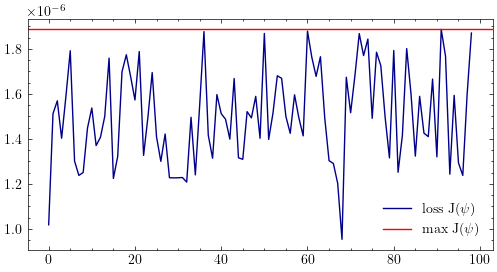

In [20]:
fig = plt.figure(figsize=(6, 3))
plt.plot(hist, label = "loss J($\psi$)", color="darkblue")
plt.axhline(loss, color = "red", label = "max J($\psi$)")
plt.legend()
plt.show()

### Primal from dual

In [24]:
def init_gamma(x, y, M, N, C, phi, psi, eps):
    Ax = np.kron(np.identity(M), np.ones(N))
    Ay = np.kron(np.ones(M), np.identity(N))
    A = np.concatenate((Ax, Ay), 0)
    c = C.flatten()
    u = np.concatenate((phi, psi), 0)
    # Slack variables
    # xi = 0 when si > 0 
    s = c - A.T @ u
    # Initialize gamma
    gamma = np.ones(M * N)
    # Number of nonzero variables
    k = M * N
    for i in range(s.size):
        if abs(s[i]) > eps:
            gamma[i] = 0.
            k -= 1
    Gamma = gamma.reshape((M, N))
    return Gamma, k

In [25]:
eps = 1e-3
Gamma_0, k = init_gamma(x, y, M, N, C, phi, psi, eps)

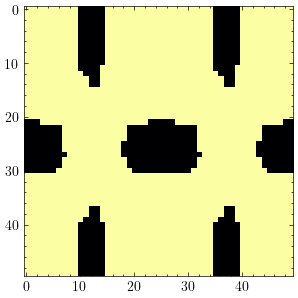

In [26]:
fig = plt.figure(figsize=(3.5, 3.5))
plt.imshow(Gamma_0, cmap = mpl.colormaps["inferno"])
plt.show()

**Constraints for $A_x \gamma = x$**

In [27]:
def linear_constraints_x(Gamma, M, N, k, eps):
    # Indices of non zeros
    Indices = []
    for i in range(M):
        for j in range(N):
            if abs(Gamma[i,j]) > eps:
                Indices.append([i, j])
    # Number of nonzeros for the ith row
    Rows = dict()
    for i in range(len(Indices)):
        j = Indices[i][0]
        if not j in Rows:
            Rows[j] = 1
        else:
            Rows[j] += 1
    # Fill A and b
    A = []
    b = []
    skip = 0
    for (i, n) in Rows.items():
        vec = np.concatenate((np.zeros(skip), np.ones(n), np.zeros(k - n - skip)), 0)
        A.append(vec)
        b.append(x[i])
        skip += n
    return A, b, Indices

**Constraints for $A_y \gamma = y$**

In [28]:
def linear_constraints_y(Gamma, M, N, k, eps):
    # Indices of non zeros (i, j)
    I = []
    for i in range(M):
        for j in range(N):
            if abs(Gamma[i,j]) > eps:
                I.append([i, j])
    # Indices of non zeros (j, i)
    Indices = []
    for j in range(N):
        for i in range(M):
            if abs(Gamma[i,j]) > eps:
                Indices.append([j, i])
    # Number of indices to skip
    Skip = dict()
    for i in range(len(Indices)):
        j = Indices[i][0]
        if not j in Skip:
            Skip[j] = 1
        else:
            Skip[j] += 1
    # Fill A and b
    A = []
    b = []
    for (j, skip) in Skip.items():
        vec = np.zeros(k)
        for idx in range(len(I)):
            ii, jj = I[idx]
            if (jj == j):
                vec[idx] = 1
        A.append(vec)
        b.append(y[j])
    return A, b

**Primal formulation**

In [29]:
def primal_from_dual(Gamma, x, y, M, N, C, k, eps):
    Ax, bx, I = linear_constraints_x(Gamma, M, N, k, eps)
    Ay, by = linear_constraints_y(Gamma, M, N, k, eps)
    # Distance vector
    v = np.zeros(k)
    for idx in range(len(I)):
        i, j = I[idx]
        v[idx] = C[i, j]
    # Variable
    z = cp.Variable(k)
    # Objective function
    obj = cp.Minimize(v.T @ z)
    # Constraints
    constraints = [z >= 0]
    for A, b in zip(Ax, bx):
        constraints.append(A @ z >= b)
    # Constraints for A_y @ z =y
    for A, b in zip(Ay, by):
        constraints.append(A @ z >= b)
    # Solve the LP problem
    problem = cp.Problem(obj, constraints)
    sol = problem.solve()
    print(f"Min <c, z> = {sol}")
    # print(z.value)
    Z = z.value
    # Gamma
    Gamma = Gamma.copy()
    for idx in range(k):
        i, j = I[idx]
        Gamma[i, j] = Z[idx]
    return Gamma

In [30]:
Gamma = primal_from_dual(Gamma_0, x, y, M, N, C, k, eps)

Min <c, z> = 3.689743876622332e-06


### Optimal transportation map

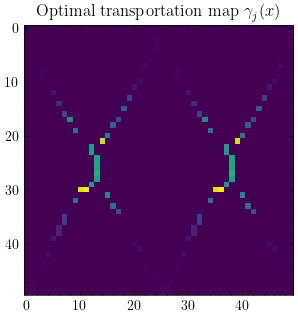

In [31]:
fig = plt.figure(figsize=(3.5, 3.5))
plt.imshow(Gamma)
plt.title("Optimal transportation map $\gamma_j(x)$")
plt.show()

**Marginal distributions**

In [32]:
def marginal_dist(Gamma, M, N, i):
    if i == 0:
        g= np.zeros(M)
        for i in range(M):
            for j in range(N):
                g[i] += Gamma[i, j]
    else:
        g = np.zeros(N)
        for i in range(M):
            for j in range(N):
                g[j] += Gamma[i,j]
    g /= g.sum()
    return g

In [33]:
gx = marginal_dist(Gamma, M, N, 0)

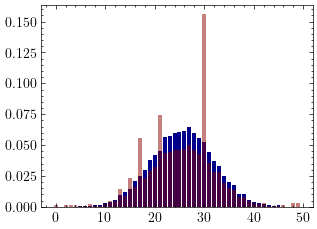

In [34]:
plt.bar(range(M), x, color = "darkblue")
plt.bar(range(M), gx, color = "darkred", alpha = .5)
plt.show()

In [35]:
gy = marginal_dist(Gamma, M, N, 1)

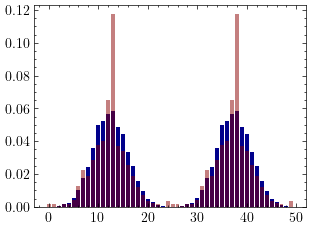

In [36]:
plt.bar(range(N), y, color = "darkblue")
plt.bar(range(N), gy, color = "darkred", alpha = .5)
plt.show()

### Exact solution with linear programming

**Dual Formulation**

In [37]:
def lp_dual(x, y, M, N, C):
    # Variables psi and phi
    psi = cp.Variable(N)
    phi = cp.Variable(M)
    # Objective funtion
    dual_obj = cp.Maximize(phi @ x.T + psi @ y.T)
    # Constraints
    dual_constraints = [psi >= 0, phi >= 0]
    for i in range(M):
        for j in range(N):
            dual_constraints.append(phi[i] + psi[j] - C[i, j] <= 0)
    # Solve the dual problem
    dual_problem = cp.Problem(dual_obj, dual_constraints)
    dual_sol = dual_problem.solve()
    print(f"max <psi, y> + <phi, x> = {dual_sol}")
    return psi.value, phi.value

In [38]:
psi_lp, phi_lp = lp_dual(x, y, M, N, C)

max <psi, y> + <phi, x> = 3.689743876592917e-06


**$\psi^{*}$ and $\psi_{lp}^{*}$**

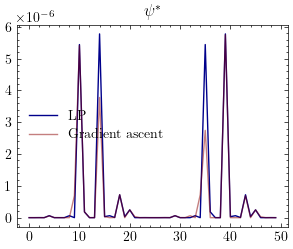

In [39]:
plt.plot(psi_lp, label = "LP", color = "darkblue")
plt.plot(psi, label = "Gradient ascent", color = "darkred", alpha = .5)
plt.legend()
plt.title("$\psi^{*}$")
plt.show()

**$\phi^{*}$ and $\phi_{lp}^{*}$**

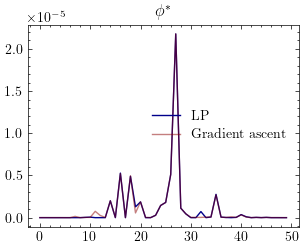

In [40]:
plt.plot(phi_lp, label = "LP", color = "darkblue")
plt.plot(phi, label = "Gradient ascent", color = "darkred", alpha = .5)
plt.legend()
plt.title("$\phi^{*}$")
plt.show()

**Primal formulation**

In [41]:
def lp_primal(x, y, M, N, C):
    z = cp.Variable(M * N)
    b = np.concatenate((x, y))
    Ax = np.kron(np.identity(M), np.ones(N))
    Ay = np.kron(np.ones(M), np.identity(N))
    A = np.concatenate((Ax, Ay), 0)
    c = C.flatten()
    primal_obj = cp.Minimize(c.T @ z)
    primal_constraints = [z >= 0, A @ z >= b]
    primal_problem = cp.Problem(primal_obj, primal_constraints)
    primal_sol = primal_problem.solve()
    print(f"Min <c, z> = {primal_sol}")
    Z = z.value.reshape(M, N)
    return Z

In [42]:
Gamma_lp = lp_primal(x, y, M, N, C)

Min <c, z> = 3.689743876055072e-06


**Optimal transportation map**

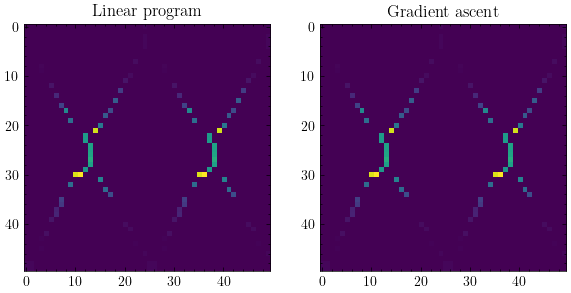

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(7,3.5))
axes[0].set_title("Linear program")
axes[0].imshow(Gamma_lp)
axes[1].imshow(Gamma)
axes[1].set_title("Gradient ascent")
plt.show()

**Marginal distributions**

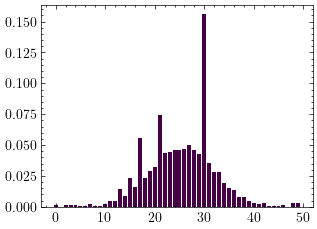

In [44]:
gx_lp = marginal_dist(Gamma_lp, M, N, 0)
plt.bar(range(N), gx, color = "darkblue")
plt.bar(range(N), gx_lp, color = "darkred", alpha = .5)
plt.show()

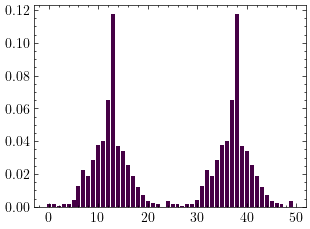

In [45]:
gy_lp = marginal_dist(Gamma, M, N, 1)
plt.bar(range(N), gy, color = "darkblue")
plt.bar(range(N), gy_lp, color = "darkred", alpha = .5)
plt.show()

### References

1. **Optimal Transport for Applied Mathematicians** by Filippo Santambrogio
2. **[Le transport optimal: de Gaspard Monge à la science des données](https://speakerdeck.com/gpeyre/le-transport-optimal-de-gaspard-monge-a-la-science-des-donnees)** by Gabriel Peyré
3. **Optimal Transportation: Duality Theory** by David Gu
4. **Projected Gradient Algorithm** by Andersen Ang